# **04 - Modelling**

## Objectives

* Augment the training dataset to provide the model more data to train on.
* Build a model architecture based on a convolutional neural network, that outputs a probability for a given leaf having powdery mildew or not.
* Fit the model to the training data.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Image montage showing a sample of the augmented training data.
* plot indicating the architecture of the convolutional neural network.
* Plot indicating the learning curve of the model in training.
* Model.h5

## Additional Comments

* No additional comments. 



---

# Import libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import joblib

from matplotlib.image import imread

---

# Set Data directory variables

## Change working directory

* Change the working directory from the current folder to /workspace/Mildew-Detection-in-Cherry-Leaves

* The output from the cell bellow should be '/workspace/Mildew-Detection-in-Cherry-Leaves'

In [4]:
os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

## Input directory variables

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_data_dir = data_dir + '/train'
val_data_dir = data_dir + '/validation'
test_data_dir = data_dir + '/test'

## Output directory variables

In [6]:
if 'outputs' not in os.listdir(current_dir):
    os.makedirs(name='outputs')

def create_output_dir(version_index):
    while True:
        try:
            os.makedirs(name=f'outputs/Version{version_index}')
            return f'outputs/Version{version_index}'
        except:
            version_index += 1
version_output = create_output_dir(1)
print(f'Current output folder is {version_output}')

Current output folder is outputs/Version3


## Data label names variables

In [7]:
labels = os.listdir(train_data_dir)
print(f'Datalabels are {labels}')

Datalabels are ['healthy', 'powdery_mildew']


## Set image shape

* As seen in notebook "01 - DataCollection" all images are 256 X 256 pixels 

* To control model performance/model size this model_shape variable might need to be set based on trial and error.

In [28]:
#As images are squares (checked in data collection notebook), we set only one variable to control both height and width
height_width = 75
#channel value set to 3 corresponding with RGB
channels = 3

img_shape = (height_width, height_width, channels)
img_shape

(100, 100, 3)

---

# Augment data

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
augment_training_data = ImageDataGenerator(rotation_range=90,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [31]:
batch_size = 20  # Set batch size
augmented_training_data = augment_training_data.flow_from_directory(train_data_dir,
                                                     target_size=img_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

augmented_training_data.class_indices

Found 2948 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [32]:
validation_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_data_object.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [33]:
test_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_data_object.class_indices

Found 838 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(20, 100, 100, 3)


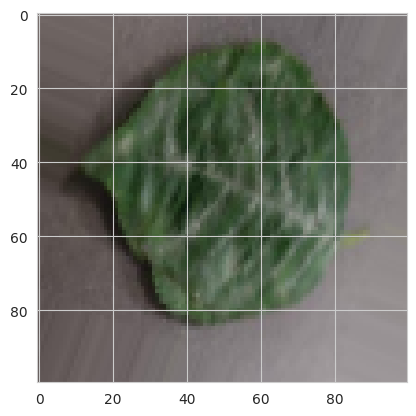

(20, 100, 100, 3)


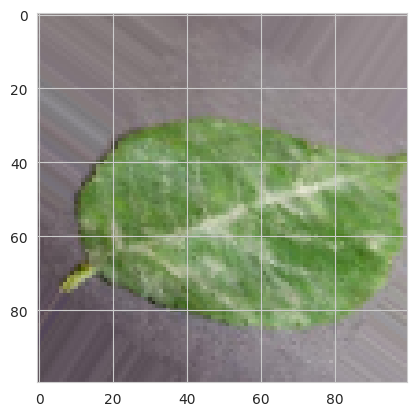

(20, 100, 100, 3)


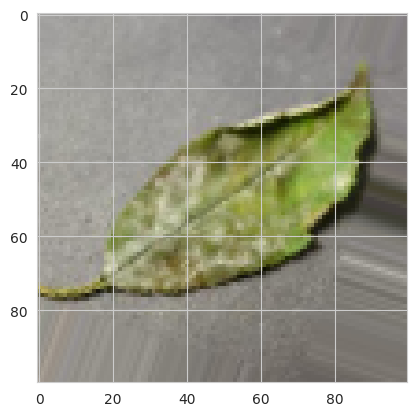

In [34]:
for _ in range(3):
    img, label = augmented_training_data.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

---

# Model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [36]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 16)      

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [39]:
model.fit(augmented_training_data,
          epochs=25,
          validation_data=validation_data_object,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/20


2023-05-11 11:45:24.001847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8229

2023-05-11 11:45:49.017291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - 26s 166ms/step - loss: 0.3761 - accuracy: 0.8229 - val_loss: 0.1028 - val_accuracy: 0.9645
Epoch 2/20
148/148 [==============================] - 26s 176ms/step - loss: 0.1164 - accuracy: 0.9579 - val_loss: 0.1361 - val_accuracy: 0.9479
Epoch 3/20
148/148 [==============================] - 22s 148ms/step - loss: 0.0972 - accuracy: 0.9674 - val_loss: 0.0225 - val_accuracy: 0.9953
Epoch 4/20
148/148 [==============================] - 12s 84ms/step - loss: 0.0723 - accuracy: 0.9763 - val_loss: 0.0881 - val_accuracy: 0.9597
Epoch 5/20
148/148 [==============================] - 12s 83ms/step - loss: 0.0565 - accuracy: 0.9841 - val_loss: 0.0956 - val_accuracy: 0.9550
Epoch 6/20
148/148 [==============================] - 15s 99ms/step - loss: 0.0549 - accuracy: 0.9861 - val_loss: 0.0211 - val_accuracy: 0.9882
Epoch 7/20
148/148 [==============================] - 25s 172ms/step - loss: 0.0564 - accuracy: 0.9813 - val_loss: 0.0096 - val_accuracy: 1.0000

In [49]:
losses = pd.DataFrame(model.history.history)


losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{version_output}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{version_output}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

## Save the fitted model to folder

In [ ]:
model.save(version_output + '/mildew_detection_model.h5')

---

# Conclusions and Next Steps

* Image montage on augmented data looks like a good representation of the dataset.
* Learning curve indicating loss and accuracy for train and validation seems to indicate that the model was able to learn to classify leaves correctly, without overfitting.
* Model is saved to versionfolder and will be evaluated in greater detail in notebook "05 - Evaluation".